# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [3]:
# Import warnings
import warnings
warnings.filterwarnings(action="ignore")


In [5]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
#import fastparquet as fq


In [6]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.__version__)
print("seaborn version:", sns.__version__)


numpy version: 1.26.4
pandas version: 2.2.3
matplotlib version: 3.10.1
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [9]:
# Try loading one file

df0 = pd.read_parquet(r"C:\Users\gilsa\OneDrive\Desktop\Sanjeev\Upgrad\EDA-Assignment\Datasets and Dictionary-NYC\Datasets and Dictionary\trip_records\2023-1.parquet", engine='fastparquet')
df0.shape

(3041714, 19)

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [14]:
#df.groupby(['date', 'hour']).size().head(50)

# As we can see from above lines's output, the dataset contains records from 2008 onwards, we are interested only in data of 2023, 
# so let's drop rest to clean the data

#df = df[df['tpep_pickup_datetime'].dt.year >= 2023]

In [111]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload


(152086, 21)

In [78]:
# from google.colab import drive
# drive.mount('/content/drive')

#data is downloaded on local machine, so mapping google drive is not needed.

In [11]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
# read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir(r'C:\Users\gilsa\OneDrive\Desktop\Sanjeev\Upgrad\EDA-Assignment\Datasets and Dictionary-NYC\Datasets and Dictionary\trip_records')

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
yearly_sampled_data = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)
        
        # Reading the current file

        df = pd.read_parquet(file_path)
           
        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.

        # Loop through dates and then loop through every hour of each date

        #since we want to take a fraction of hourly data for each date of the month, lets add the date, hour columns to make data extraction easy

        if 'date' not in df.columns:
            df['date'] = df['tpep_pickup_datetime'].dt.date
        if 'hour' not in df.columns:
            df['hour'] = df['tpep_pickup_datetime'].dt.hour

        sampled_data = pd.DataFrame()
        # Now we will go over each date in the monthly data

        for date in df['date'].unique():
            date_data = df[df['date'] == date]
            
            # Iterate through each hour of the selected date

            for hour in range(24):
                hour_data = date_data[date_data['hour'] == hour]
                count = len(hour_data)    #take a count of hour data, it should not be so small that 0.05 fraction becomes < 1.

                # Sample 5% of the hourly data randomly

                if count > 0:
                    sample = hour_data.sample(frac=0.05, random_state=42)
                    
                    
                                
                # add data of this hour to the dataframe
                    sampled_data = pd.concat([sampled_data, sample], ignore_index=True)

        # Concatenate the sampled data of all the dates to a single dataframe
        yearly_sampled_data = pd.concat([yearly_sampled_data, sampled_data], ignore_index=True)
        print(f"Sampled data shape after file {file_name}: {yearly_sampled_data.shape}")
            
    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Sampled data shape after file 2023-1.parquet: (152087, 21)
Sampled data shape after file 2023-10.parquet: (326342, 22)


KeyboardInterrupt: 

After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
#since we have some null records in the samled dataFrame, let's drop them.

yearly_sampled_data.shape

#With 0.05 faction the sampled data records comes out to be 1896400, so keeping it and ignoring the advise to bring it down to 2.5 L- 3L.



In [84]:
# Store the df in csv/parquet
yearly_sampled_data.to_parquet(r'C:\Users\gilsa\OneDrive\Desktop\Sanjeev\Upgrad\EDA-Assignment\sampled_data.parquet')

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [16]:
# Load the new data file

df=pd.read_parquet(r"C:\Users\gilsa\OneDrive\Desktop\Sanjeev\Upgrad\EDA-Assignment\sampled_data.parquet")

In [18]:
df.tail()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1896395         2  2023-09-30 23:46:34   2023-09-30 23:53:20              1.0   
1896396         1  2023-09-30 23:44:51   2023-09-30 23:49:05              3.0   
1896397         2  2023-09-30 23:11:05   2023-09-30 23:18:42              1.0   
1896398         1  2023-09-30 23:26:31   2023-10-01 00:04:05              2.0   
1896399         2  2023-09-30 23:19:47   2023-09-30 23:33:36              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  PULocationID  \
1896395           0.79         1.0                  N           231   
1896396           0.50         1.0                  N           158   
1896397           1.09         1.0                  N           161   
1896398          13.20         1.0                  N           164   
1896399           2.97         1.0                  N           231   

         DOLocationID  payment_type  ...  mta_tax  tip_amount  tolls_amount  \
1896395           231             1  ...      0.5        2.00           0.0   
1896396            68             1  ...      0.5        2.15           0.0   
1896397           162             1  ...      0.5        2.86           0.0   
1896398            14             2  ...      0.5        0.00           0.0   
1896399            68             1  ...      0.5        4.40           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
1896395                    1.0         15.60                   2.5   
1896396                    1.0         12.95                   2.5   
1896397                    1.0         17.16                   2.5   
1896398                    1.0         59.80                   2.5   
1896399                    1.0         26.40                   2.5   

         airport_fee        date  hour Airport_fee  
1896395          NaN  2023-09-30    23         0.0  
1896396          NaN  2023-09-30    23         0.0  
1896397          NaN  2023-09-30    23         0.0  
1896398          NaN  2023-09-30    23         0.0  
1896399          NaN  2023-09-30    23         0.0  

[5 rows x 22 columns]

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [20]:
# Fix the index and drop any columns that are not needed

df.reset_index(drop=True, inplace=True)

# we can drop store_and_fwd_flag column as it doesn't seems adding any value

df.drop(columns='store_and_fwd_flag', axis=1, inplace=True)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [22]:
# Combine the two airport fee columns

df['airport_fee'] = df['airport_fee'] + df['Airport_fee']

# After combining the airport fee columns we can drop one of those
df.drop(columns='Airport_fee', axis=1, inplace=True)

In [24]:
df['RatecodeID'].value_counts()

RatecodeID
1.0     1729259
2.0       71670
99.0      10472
5.0       10275
3.0        6124
4.0        3723
6.0           3
Name: count, dtype: int64

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [26]:
# check where values of fare amount are negative

df[df['total_amount'] < 0 ]

#We get 78 such records after running above query

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
3966            2  2023-01-02 05:12:19   2023-01-02 05:41:45              1.0   
9093            2  2023-01-03 14:24:45   2023-01-03 14:25:14              1.0   
77200           2  2023-01-17 12:37:35   2023-01-17 13:24:00              1.0   
77920           2  2023-01-17 15:03:44   2023-01-17 15:36:28              1.0   
86509           2  2023-01-19 09:50:26   2023-01-19 09:58:13              1.0   
...           ...                  ...                   ...              ...   
1734702         2  2023-07-27 17:56:27   2023-07-27 18:00:12              1.0   
1742776         2  2023-07-29 03:47:56   2023-07-29 03:48:34              4.0   
1762681         2  2023-09-02 18:29:48   2023-09-02 18:30:13              3.0   
1774112         2  2023-09-05 15:32:01   2023-09-05 15:43:35              1.0   
1893750         2  2023-09-30 16:35:07   2023-09-30 16:35:13              1.0   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
3966             17.07         3.0           142             1             2   
9093              0.00         2.0           132           132             2   
77200            17.68         2.0           230           132             2   
77920             4.12         1.0           239           168             2   
86509             0.50         1.0           161            43             2   
...                ...         ...           ...           ...           ...   
1734702           0.66         1.0           113           234             2   
1742776           0.00         5.0            79            79             4   
1762681           0.00         2.0            74            74             2   
1774112           0.01         1.0           161           170             2   
1893750           0.00         5.0           141           141             2   

         fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
3966             0.0    0.0      0.0         0.0           0.0   
9093             0.0    0.0     -0.5         0.0           0.0   
77200            0.0    0.0     -0.5         0.0           0.0   
77920            0.0    0.0     -0.5         0.0           0.0   
86509            0.0    0.0     -0.5         0.0           0.0   
...              ...    ...      ...         ...           ...   
1734702          0.0    0.0     -0.5         0.0           0.0   
1742776          0.0    0.0      0.0         0.0           0.0   
1762681          0.0    0.0     -0.5         0.0           0.0   
1774112          0.0    0.0     -0.5         0.0           0.0   
1893750          0.0    0.0      0.0         0.0           0.0   

         improvement_surcharge  total_amount  congestion_surcharge  \
3966                      -1.0         -1.00                   0.0   
9093                      -1.0         -5.25                  -2.5   
77200                     -1.0         -4.00                  -2.5   
77920                     -1.0         -4.00                  -2.5   
86509                     -1.0         -4.00                  -2.5   
...                        ...           ...                   ...   
1734702                   -1.0         -4.00                  -2.5   
1742776                   -1.0         -3.50                  -2.5   
1762681                   -1.0         -1.50                   0.0   
1774112                   -1.0         -4.00                  -2.5   
1893750                   -1.0         -3.50                  -2.5   

         airport_fee        date  hour  
3966             NaN  2023-01-02     5  
9093             NaN  2023-01-03    14  
77200            NaN  2023-01-17    12  
77920            NaN  2023-01-17    15  
86509            NaN  2023-01-19     9  
...              ...         ...   ...  
1734702          NaN  2023-07-27    17  
1742776          NaN  2023-07-29     3  
1762681          NaN  2023-09-02    18  
1774112          NaN  2023-09-0

Did you notice something different in the `RatecodeID` column for above records?

In [28]:
# Analyse RatecodeID for the negative fare amounts
df[df['total_amount'] < 0]['RatecodeID'].value_counts()


RatecodeID
1.0    49
2.0    24
5.0     3
3.0     1
4.0     1
Name: count, dtype: int64

In [30]:
# Find which columns have negative values

cols_to_check = ['passenger_count','RatecodeID','PULocationID','DOLocationID','payment_type',
                 'fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge',
                 'total_amount','congestion_surcharge','airport_fee']

negative_value_columns = [col for col in cols_to_check if (df[col] < 0).any()]
print(negative_value_columns)

# These columns have -ve values   ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']


In [32]:
# fix these negative values

# As under normal circumstances total_amount, tax, surchange can not be -ve, dropping these rows makes sense.

cols_to_check = ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 
                 'congestion_surcharge', 'airport_fee']

# Drop rows where any of these columns have negative values
df = df[~(df[cols_to_check] < 0).any(axis=1)]


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [34]:
# Find the proportion of missing values in each column

df.isnull().mean()

VendorID                 0.00000
tpep_pickup_datetime     0.00000
tpep_dropoff_datetime    0.00000
passenger_count          0.03421
trip_distance            0.00000
RatecodeID               0.03421
PULocationID             0.00000
DOLocationID             0.00000
payment_type             0.00000
fare_amount              0.00000
extra                    0.00000
mta_tax                  0.00000
tip_amount               0.00000
tolls_amount             0.00000
improvement_surcharge    0.00000
total_amount             0.00000
congestion_surcharge     0.03421
airport_fee              1.00000
date                     0.00000
hour                     0.00000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [36]:
# Display the rows with null values
df.passenger_count.isnull()  #df.passenger_count.isnull().sum()  for total count of missing values
# Impute NaN values in 'passenger_count'
#We can see the mode , most frequest occurance of passenger count is 1, so will impute the NaN values with 1
df['passenger_count'] = df.passenger_count.fillna(df['passenger_count'].mode()[0])

Did you find zeroes in passenger_count? Handle these.

In [39]:
df[df['passenger_count'] == 0]

# 29681 records have passenger count as 0, we will impute it with it's mode which is 1
mode_value = df['passenger_count'].mode()[0]
df.loc[df['passenger_count'] == 0, 'passenger_count'] = mode_value


**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [42]:
# Fix missing values in 'RatecodeID'
df['RatecodeID'].isnull().sum()

#64874 rows have RatecodeID as null
#fill these with mode of RatecodeID

df['RatecodeID'] = df.RatecodeID.fillna(df['RatecodeID'].mode()[0])



**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [45]:
# handle null values in congestion_surcharge

df['congestion_surcharge'] = df.congestion_surcharge.fillna(df['congestion_surcharge'].mode()[0])
df['congestion_surcharge'].isnull().sum()

0

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [48]:
# Handle any remaining missing values

df.isnull().sum()

# from above we can see airport_fee is null for 1747845 records , this could be as taxi didn't went to airport, so we will replace these with 0

df['airport_fee'].fillna(0, inplace=True)

#We are given data for 2023 but there are some rows from 2022 , lets drop them before moving ahead.

df = df[df['tpep_pickup_datetime'].dt.year >= 2023]

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [52]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns

pd.set_option('display.float_format', '{:.3f}'.format)
df.describe()


VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count 1896320.000                     1896320                     1896320   
mean        1.733  2023-07-02 19:59:09.002166  2023-07-02 20:16:34.993049   
min         1.000         2023-01-01 00:00:57         2023-01-01 00:09:35   
25%         1.000  2023-04-02 16:09:10.500000         2023-04-02 16:27:21   
50%         2.000         2023-06-27 15:43:18         2023-06-27 16:00:28   
75%         2.000  2023-10-06 19:36:21.750000  2023-10-06 19:53:03.250000   
max         6.000         2023-12-31 23:57:51         2024-01-01 20:50:55   
std         0.448                         NaN                         NaN   

       passenger_count  trip_distance  RatecodeID  PULocationID  DOLocationID  \
count      1896320.000    1896320.000 1896320.000   1896320.000   1896320.000   
mean             1.372          3.858       1.613       165.282       164.051   
min              1.000          0.000       1.000         1.000         1.000   
25%              1.000          1.050       1.000       132.000       114.000   
50%              1.000          1.800       1.000       162.000       162.000   
75%              1.000          3.400       1.000       234.000       234.000   
max              9.000     126360.460      99.000       265.000       265.000   
std              0.864        129.411       7.267        64.001        69.802   

       payment_type  fare_amount       extra     mta_tax  tip_amount  \
count   1896320.000  1896320.000 1896320.000 1896320.000 1896320.000   
mean          1.164       19.920       1.588       0.495       3.547   
min           0.000        0.000       0.000       0.000       0.000   
25%           1.000        9.300       0.000       0.500       1.000   
50%           1.000       13.500       1.000       0.500       2.850   
75%           1.000       21.900       2.500       0.500       4.420   
max           4.000   143163.450      20.800       4.000     223.080   
std           0.508      105.539       1.829       0.048       4.055   

       tolls_amount  improvement_surcharge  total_amount  \
count   1896320.000            1896320.000   1896320.000   
mean          0.597                  0.999        28.983   
min           0.000                  0.000         0.000   
25%           0.000                  1.000        15.960   
50%           0.000                  1.000        21.000   
75%           0.000                  1.000        30.940   
max         143.000                  1.000    143167.450   
std           2.188                  0.028       106.418   

       congestion_surcharge  airport_fee        hour  
count           1896320.000  1896320.000 1896320.000  
mean                  2.314        0.000      14.265  
min                   0.000        0.000       0.000  
25%                   2.500        0.000      11.000  
50%                   2.500        0.000      15.000  
75%                   2.500        0.000      19.000  
max                   2.500        0.000      23.000  
std                   0.656        0.000       5.807

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [57]:
df.shape

(1896320, 20)

In [59]:
# remove passenger_count > 6
df = df[df['passenger_count'] <= 6]

In [61]:
df.shape

(1896299, 20)

In [63]:
# Continue with outlier handling

def cleanup_outliers(df):
    
    #Drop Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
    
    df = df[~((df['trip_distance'] < 0.01) & (df['fare_amount'] > 300))]
    
    # Drop Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
    df = df[~((df['trip_distance'] == 0) & 
              (df['fare_amount'] == 0) & 
              (df['PULocationID'] != df['DOLocationID']))]
    
    #Drop entries where `trip_distance` is more than 250  miles.
    df = df[df['trip_distance'] <= 250]
    
    #Drop Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)
    
    df = df[df['payment_type'] != 0]
    return df 

df = cleanup_outliers(df)

In [64]:
# Do any columns need standardising?

#Not finding need for standardization of any column

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [68]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'date',
 'hour']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


Ans:

Numerical Variables:

passenger_count
trip_distance
pickup_hour
trip_duration

Categorical Variables:

VendorID
tpep_pickup_datetime
tpep_dropoff_datetime
RatecodeID
PULocationID
DOLocationID
payment_type


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

Ans:- numerical

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

hour
0      51162
1      34278
2      22551
3      14709
4       9436
5      10019
6      24467
7      48990
8      68274
9      78285
10     85628
11     93034
12    100999
13    104104
14    111568
15    114292
16    114281
17    123557
18    129184
19    115915
20    103435
21    103165
22     95158
23     74825
Name: count, dtype: int64


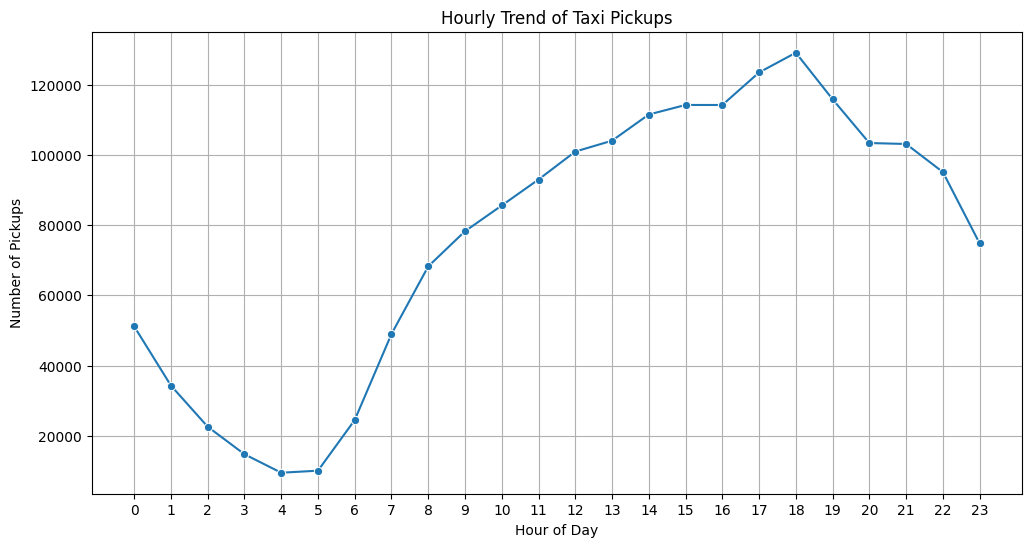

In [70]:
# Find and show the hourly trends in taxi pickups

#We had already extracted hour and date above, so will start analyzing..
import matplotlib.pyplot as plt

hourly_pickups = df['hour'].value_counts().sort_index()
print(hourly_pickups)

plt.figure(figsize=(12,6))
sns.lineplot(x=hourly_pickups.index, y=hourly_pickups.values, marker='o')
plt.title('Hourly Trend of Taxi Pickups')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


day
0    228947
1    265922
2    281548
3    287258
4    271608
5    265849
6    230184
Name: count, dtype: int64
pickup_day_name
Mon    228947
Tue    265922
Wed    281548
Thu    287258
Fri    271608
Sat    265849
Sun    230184
Name: count, dtype: int64


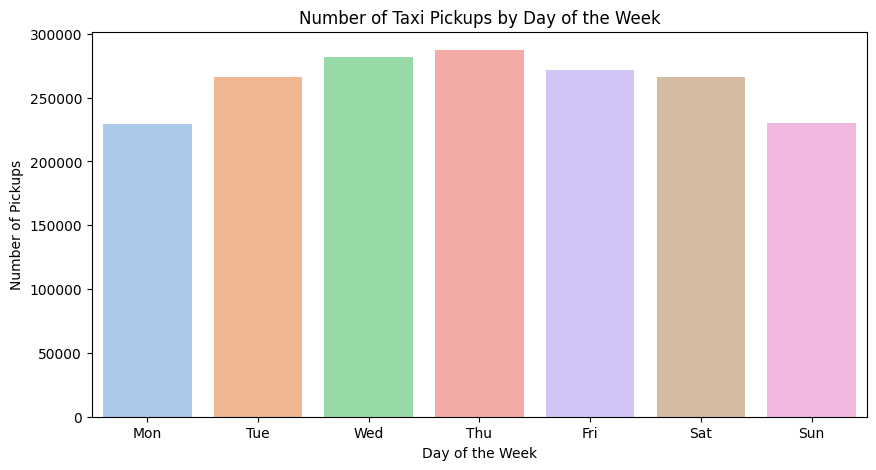

In [72]:
# Find and show the daily trends in taxi pickups (days of the week)
df['day'] = df['tpep_pickup_datetime'].dt.dayofweek

daily_pickups = df['day'].value_counts().sort_index()
print(daily_pickups)

day_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df['pickup_day_name'] = df['day'].map(day_mapping)

daily_pickups_named = df['pickup_day_name'].value_counts().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
print(daily_pickups_named)

plt.figure(figsize=(10,5))
sns.barplot(x=daily_pickups_named.index, y=daily_pickups_named.values, palette='pastel')
plt.title('Number of Taxi Pickups by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pickups')
plt.show()


pickup_month
1     148466
2     140707
3     164277
4     158374
5     168968
6     158979
7     139721
8     135247
9     133927
10    166513
11    158389
12    157748
Name: count, dtype: int64


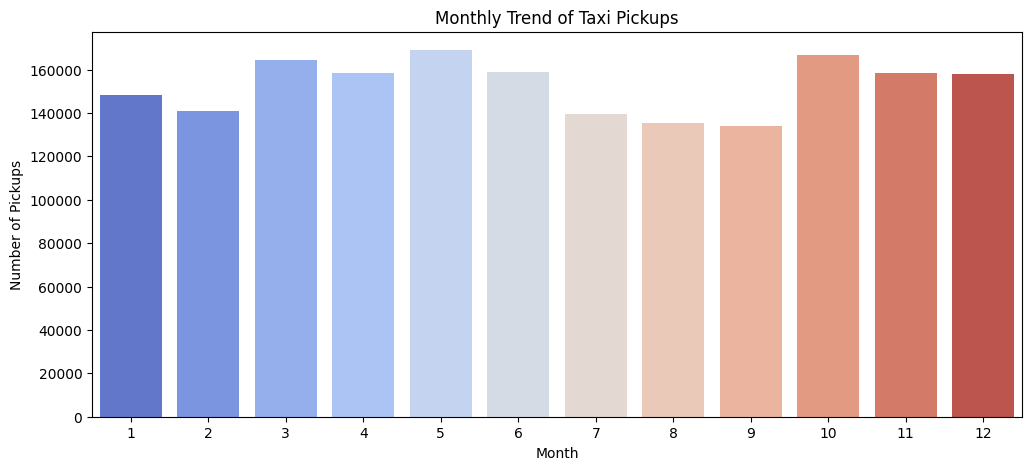

In [74]:
# Show the monthly trends in pickups

df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

monthly_pickups = df['pickup_month'].value_counts().sort_index()
print(monthly_pickups)

plt.figure(figsize=(12,5))
sns.barplot(x=monthly_pickups.index, y=monthly_pickups.values, palette='coolwarm')
plt.title('Monthly Trend of Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.show()

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [76]:
# Analyse the above parameters

columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

check_summary = pd.DataFrame({
    'Zero Values': [(df[col] == 0).sum() for col in columns_to_check],
    'Negative Values': [(df[col] < 0).sum() for col in columns_to_check]
}, index=columns_to_check)

print(check_summary)


               Zero Values  Negative Values
fare_amount            501                0
tip_amount          410160                0
total_amount           255                0
trip_distance        22911                0


Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?



**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [78]:
# Create a df with non zero entries for the selected parameters.
#tip_amount can be 0 legitimately if no tips were offered, so filling 0 tips rows doesn't make sense. Let's fill rest of the zero value columns

df['fare_amount'] = df['fare_amount'].replace(0, df['fare_amount'].median())

#Assuming here that 0 trip_distance could be data entry error or very short trips, say , less than a mile, 
#so will fill these with mode which is 0.9 miles

mode_distance = df[df['trip_distance'] > 0]['trip_distance'].mode()[0]
df.loc[df['trip_distance'] == 0, 'trip_distance'] = mode_distance

#fare_amount, tital_amount =0 , looks misrecorded, so will drop them

df = df[(df['fare_amount'] != 0) & (df['total_amount'] != 0)]


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

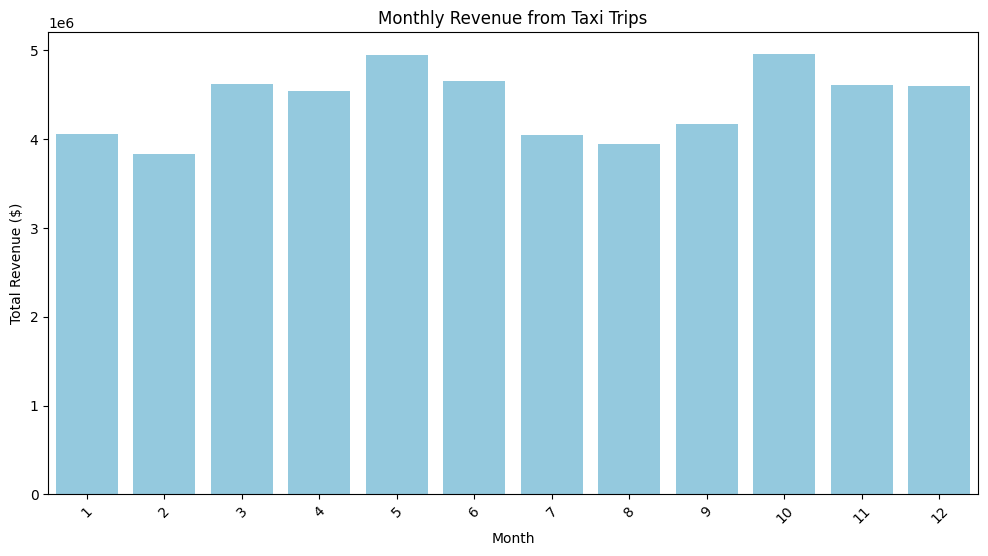

In [80]:
# Group data by month and analyse monthly revenue

monthly_revenue = df.groupby('pickup_month')['total_amount'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='pickup_month', y='total_amount', data=monthly_revenue, color='skyblue')
plt.title('Monthly Revenue from Taxi Trips')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.show()

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [82]:
# Calculate proportion of each quarter
df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q')
quarterly_revenue = df.groupby('pickup_quarter')['total_amount'].sum().reset_index()
quarterly_revenue['proportion'] = (quarterly_revenue['total_amount'] / quarterly_revenue['total_amount'].sum()) * 100
print(quarterly_revenue)

  pickup_quarter  total_amount  proportion
0         2023Q1  12514252.080      23.611
1         2023Q2  14140818.340      26.680
2         2023Q3  12171979.480      22.965
3         2023Q4  14174580.580      26.744


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

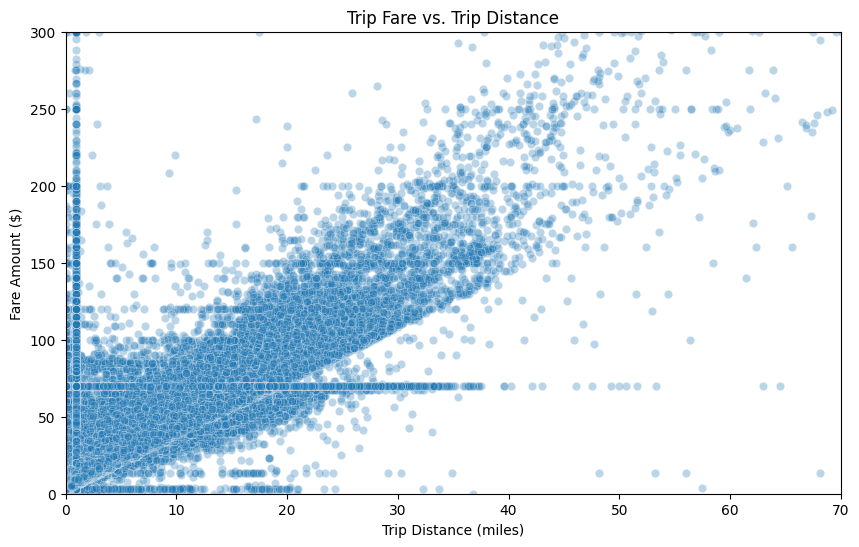

In [84]:
# Show how trip fare is affected by distance
df = df[df['trip_distance'] > 0]  # leaving out 0 distances
plt.figure(figsize=(10,6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df, alpha=0.3)
plt.title('Trip Fare vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.xlim(0, 70)  
plt.ylim(0, 300)  
plt.show()



**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1831061 entries, 0 to 1896399
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           int64         
 9   fare_amount            float64       
 10  extra                  float64       
 11  mta_tax                float64       
 12  tip_amount             float64       
 13  tolls_amount           float64       
 14  improvement_surcharge  float64       
 15  total_amount           float64       
 16  congestion_surcharge   float64       
 17  airport_fee            float64       
 18  date                   obje

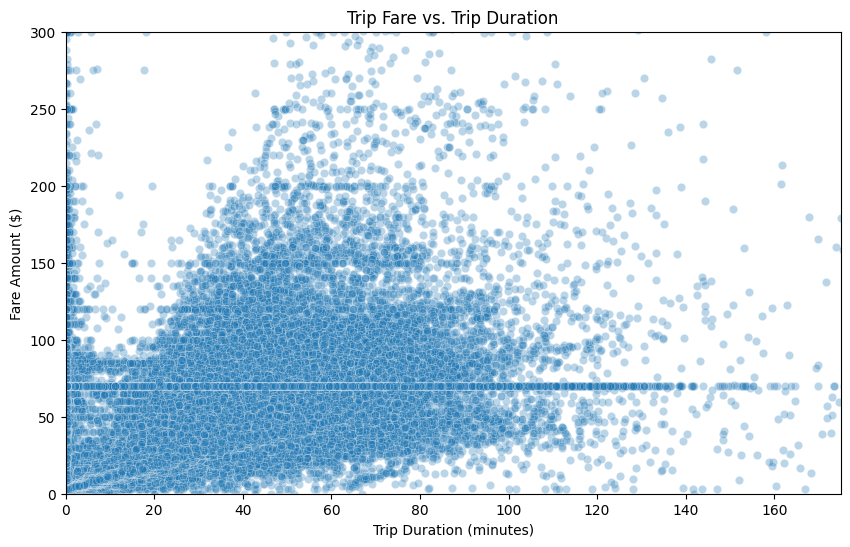

In [85]:
# Show relationship between fare and trip duration
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

plt.figure(figsize=(10,6))
sns.scatterplot(x='trip_duration', y='fare_amount', data=df, alpha=0.3)
plt.title('Trip Fare vs. Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.xlim(0, 175)   
plt.ylim(0, 300)   
plt.show()

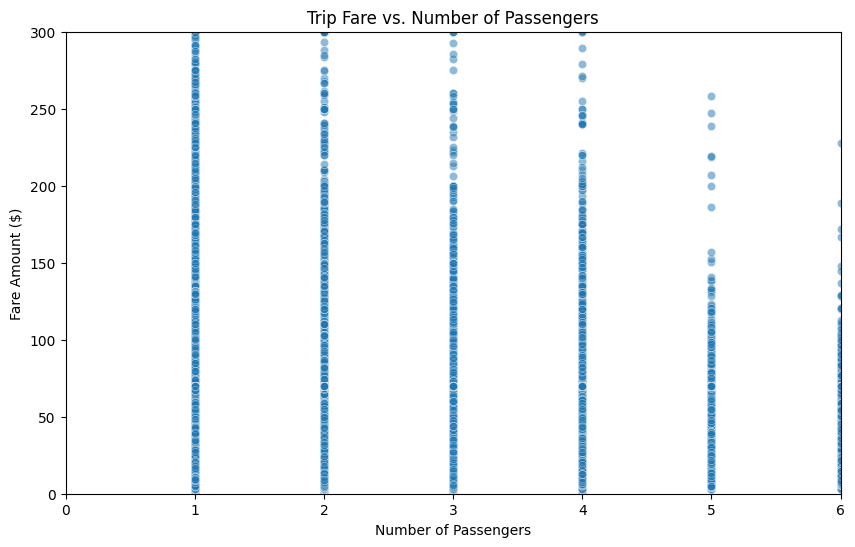

In [126]:
# Show relationship between fare and number of passengers

plt.figure(figsize=(10,6))
sns.scatterplot(x='passenger_count', y='fare_amount', data=df, alpha=0.5)
plt.title('Trip Fare vs. Number of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Fare Amount ($)')
plt.xlim(0, 6)   
plt.ylim(0, 300)
plt.show()

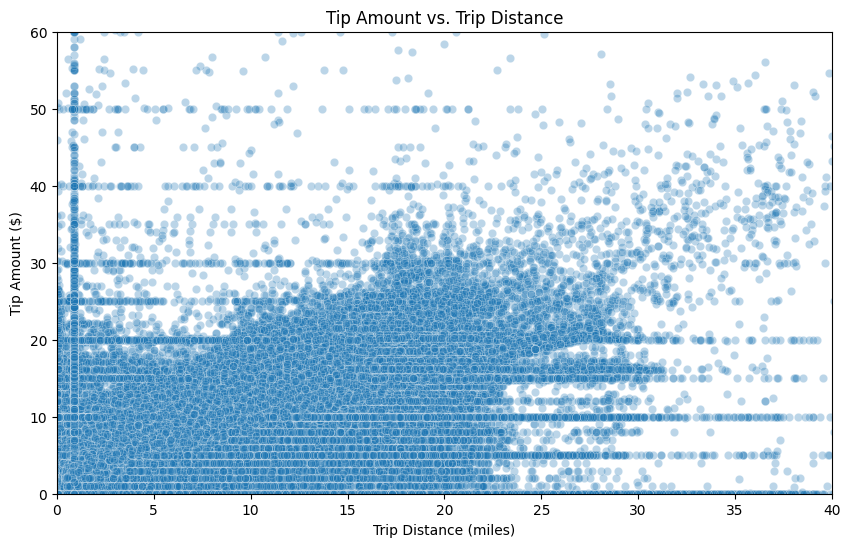

In [87]:
# Show relationship between tip and trip distance

df_nonzeroDistance = df[df['trip_distance'] > 0]

plt.figure(figsize=(10,6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=df_nonzeroDistance, alpha=0.3)
plt.title('Tip Amount vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.xlim(0, 40)  
plt.ylim(0, 60)  
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

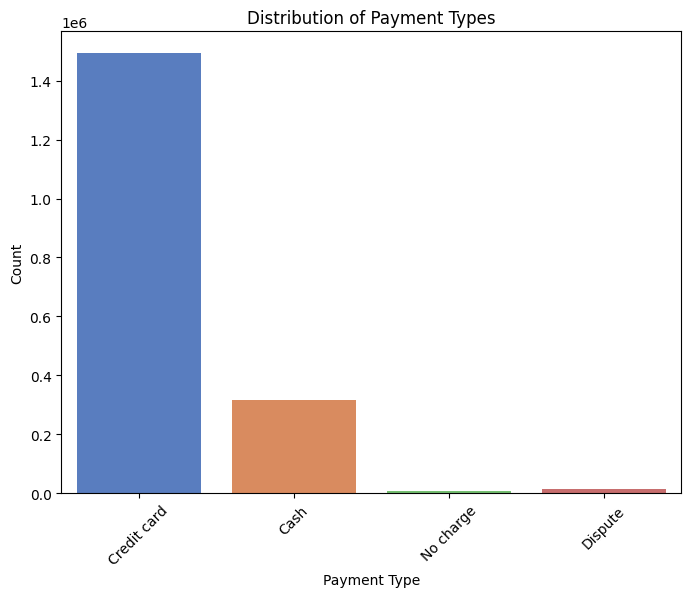

In [90]:
# Analyse the distribution of different payment types (payment_type).

payment_type_counts = df['payment_type'].value_counts().reset_index()
payment_type_counts.columns = ['Payment Type', 'Count']

plt.figure(figsize=(8,6))
sns.barplot(x='Payment Type', y='Count', data=payment_type_counts, palette='muted')
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Credit card', 'Cash', 'No charge', 'Dispute'], rotation=45)
plt.show()



- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [136]:
#!pip install geopandas

   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.2 MB 5.6 MB/s eta 0:00:03
   ---- ----------------------------------- 1.8/16.2 MB 4.4 MB/s eta 0:00:04
   ------- -------------------------------- 2.9/16.2 MB 4.3 MB/s eta 0:00:04
   --------- ------------------------------ 3.7/16.2 MB 4.2 MB/s eta 0:00:03
   ----------- ---------------------------- 4.5/16.2 MB 4.1 MB/s eta 0:00:03
   ------------ --------------------------- 5.2/16.2 MB 4.1 MB/s eta 0:00:03
   -------------- ------------------------- 6.0/16.2 MB 4.1 MB/s eta 0:00:03
   ---------------- ----------------------- 6.8/16.2 MB 4.0 MB/s eta 0:00:03
   ------------------ --------------------- 7.6/16.2 MB 4.0 MB/s eta 0:00:03
   -------------------- ------------------- 8.1/16.2 MB 4.0 MB/s eta 0:00:02
   ---------------------- ----------------- 9.2/16.2 MB 4.0 MB/s eta 0:00:02
   ------------------------ --------------- 10.0/16.2 MB 4.0 MB/s eta 0:00:02
   --

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [92]:
import geopandas as gpd

# Read the shapefile using geopandas

zones = gpd.read_file(r"C:\Users\gilsa\OneDrive\Desktop\Sanjeev\Upgrad\EDA-Assignment\Datasets and Dictionary-NYC\Datasets and Dictionary\taxi_zones\taxi_zones.shp")
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1       0.116       0.001           Newark Airport           1   
1         2       0.433       0.005              Jamaica Bay           2   
2         3       0.084       0.000  Allerton/Pelham Gardens           3   
3         4       0.044       0.000            Alphabet City           4   
4         5       0.092       0.000            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

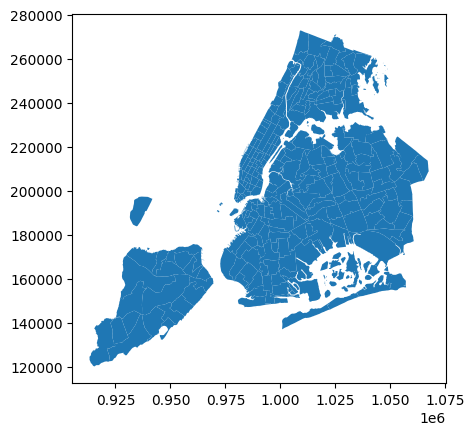

In [95]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [99]:
# Merge zones and trip records using locationID and PULocationID

pickup_merged = df.merge(zones, left_on='PULocationID', right_on='LocationID', how='left')

pickup_merged.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15            1.000   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46            2.000   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36            3.000   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55            1.000   
4         1  2023-01-01 00:42:56   2023-01-01 01:16:33            2.000   

   trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0          7.740       1.000           138           256             2   
1          1.240       1.000           161           237             1   
2          1.440       1.000           237           141             2   
3          0.540       1.000           143           142             2   
4          7.100       1.000           246            37             1   

   fare_amount  ...  pickup_month  pickup_quarter  trip_duration  OBJECTID  \
0       32.400  ...             1          2023Q1         15.950   138.000   
1        7.900  ...             1          2023Q1          5.083   161.000   
2       11.400  ...             1          2023Q1         10.550   237.000   
3        6.500  ...             1          2023Q1          5.417   143.000   
4       34.500  ...             1          2023Q1         33.617   246.000   

   Shape_Leng  Shape_Area                       zone  LocationID    borough  \
0       0.107       0.001          LaGuardia Airport     138.000     Queens   
1       0.036       0.000             Midtown Center     161.000  Manhattan   
2       0.042       0.000      Upper East Side South     237.000  Manhattan   
3       0.054       0.000        Lincoln Square West     143.000  Manhattan   
4       0.069       0.000  West Chelsea/Hudson Yards     246.000  Manhattan   

                                            geometry  
0  MULTIPOLYGON (((1019904.219 225677.983, 102031...  
1  POLYGON ((991081.026 214453.698, 990952.644 21...  
2  POLYGON ((993633.442 216961.016, 993507.232 21...  
3  POLYGON ((989338.1 223572.253, 989368.225 2235...  
4  POLYGON ((983031.177 217138.506, 983640.32 216...  

[5 rows x 32 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [102]:
# Group data by location and calculate the number of trips

pickup_counts = df.groupby('PULocationID').size().reset_index(name='trip_count')
print(pickup_counts)


     PULocationID  trip_count
0               1         214
1               2           2
2               3          40
3               4        1861
4               5          13
..            ...         ...
252           261        9606
253           262       23616
254           263       34869
255           264       17505
256           265         992

[257 rows x 2 columns]


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [105]:
# Merge trip counts back to the zones GeoDataFrame

zones = zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID', how='left')

# Fill NaN trip counts with zero (for zones with no trips)
zones['trip_count'] = zones['trip_count'].fillna(0)

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

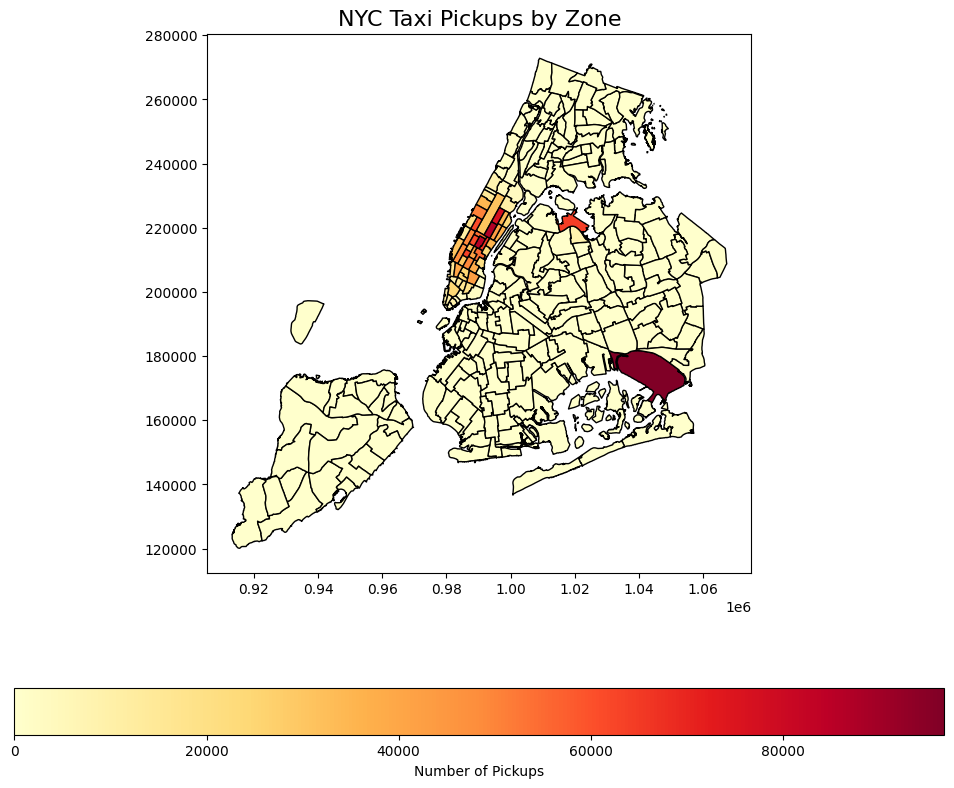

In [110]:
# Define figure and axis

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the map and display it
zones.plot(column='trip_count',
                       ax=ax,
                       cmap='YlOrRd',
                       legend=True,
                       legend_kwds={'label': "Number of Pickups", 'orientation': "horizontal"},
                       edgecolor='black')

# Set title
ax.set_title('NYC Taxi Pickups by Zone', fontsize=16)

# Remove axis clutter
#ax.set_axis_off()

legend = True

# Display the plot
plt.show()


In [112]:
# can you try displaying the zones DF sorted by the number of trips?
zones.sort_values(by='trip_count', ascending=False)


OBJECTID  Shape_Leng  Shape_Area  \
131       132       0.245       0.002   
236       237       0.042       0.000   
160       161       0.036       0.000   
235       236       0.044       0.000   
161       162       0.035       0.000   
..        ...         ...         ...   
29         30       0.095       0.000   
98         99       0.183       0.001   
109       110       0.104       0.001   
175       176       0.152       0.001   
102       103       0.014       0.000   

                                              zone  LocationID        borough  \
131                                    JFK Airport         132         Queens   
236                          Upper East Side South         237      Manhattan   
160                                 Midtown Center         161      Manhattan   
235                          Upper East Side North         236      Manhattan   
161                                   Midtown East         162      Manhattan   
..                                             ...         ...            ...   
29                                   Broad Channel          30         Queens   
98                                 Freshkills Park          99  Staten Island   
109                               Great Kills Park         110  Staten Island   
175                                        Oakwood         176  Staten Island   
102  Governor's Island/Ellis Island/Liberty Island         103      Manhattan   

                                              geometry  PULocationID  \
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...       132.000   
236  POLYGON ((993633.442 216961.016, 993507.232 21...       237.000   
160  POLYGON ((991081.026 214453.698, 990952.644 21...       161.000   
235  POLYGON ((995940.048 221122.92, 995812.322 220...       236.000   
161  POLYGON ((992224.354 214415.293, 992096.999 21...       162.000   
..                                                 ...           ...   
29   POLYGON ((1034013.272 163473.152, 1034866.459 ...           NaN   
98   POLYGON ((937468.341 152998.406, 937320.263 15...           NaN   
109  POLYGON ((951420.092 139894.411, 951856.209 13...           NaN   
175  POLYGON ((950393.94 148827.195, 950393.983 148...           NaN   
102  POLYGON ((972079.575 190732.429, 972184.766 19...           NaN   

     trip_count  
131   96802.000  
236   86899.000  
160   85942.000  
235   77509.000  
161   65632.000  
..          ...  
29        0.000  
98        0.000  
109       0.000  
175       0.000  
102       0.000  

[263 rows x 9 columns]

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [122]:
# Find routes which have the slowest speeds at different times of the day

route_speed = df.groupby(['PULocationID', 'DOLocationID', 'hour']).agg({
    'trip_distance': 'mean',
    'trip_duration': 'mean'
}).reset_index()


# Calculate average speed in miles per hour
route_speed['avg_speed_mph'] = route_speed['trip_distance'] / route_speed['hour']
route_speed['avg_speed_mph'] = route_speed['avg_speed_mph'].round(3)

# Sort by avg_speed to find slowest routes
slowest_routes = route_speed.sort_values(by='avg_speed_mph').head(10)

# Display slowest routes
slowest_routes

PULocationID  DOLocationID  hour  trip_distance  trip_duration  \
1544             10           132    22          0.010          0.100   
91546           198           198    17          0.020          0.200   
90734           190           190    15          0.010          0.683   
16484            65            65    16          0.020          0.117   
3921             19            19    13          0.010          1.917   
5541             28           130    17          0.010          0.067   
22222            71            71    14          0.010          2.067   
73616           159           159    18          0.010          0.083   
91117           194           194    16          0.010         12.267   
43321           116           264    21          0.020          0.033   

       avg_speed_mph  
1544           0.000  
91546          0.001  
90734          0.001  
16484          0.001  
3921           0.001  
5541           0.001  
22222          0.001  
73616          0.001  
91117          0.001  
43321          0.001

How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

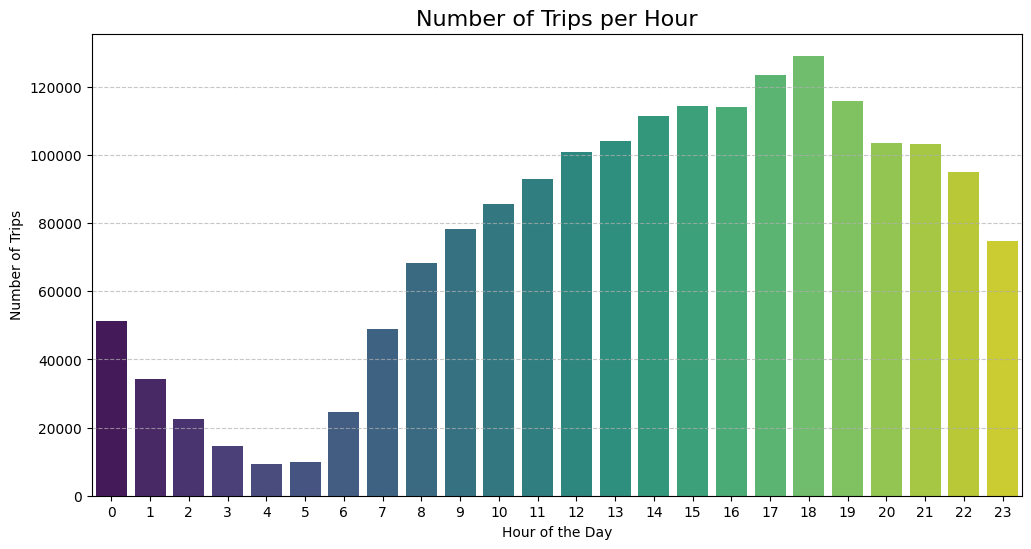

Busiest Hour: 18:00 with hour
0    51158
1    34275
2    22550
3    14707
4     9436
Name: count, dtype: int64 trips


In [126]:
# Visualise the number of trips per hour and find the busiest hour

# Count number of trips per hour
hourly_trip_counts = df['hour'].value_counts().sort_index()

# Plot the hourly trip counts
plt.figure(figsize=(12,6))
sns.barplot(x=hourly_trip_counts.index, y=hourly_trip_counts.values, palette='viridis')

plt.title('Number of Trips per Hour', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Find the busiest hour
busiest_hour = hourly_trip_counts.idxmax()
print(f"Busiest Hour: {busiest_hour}:00 with {hourly_trip_counts.head()} trips")


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

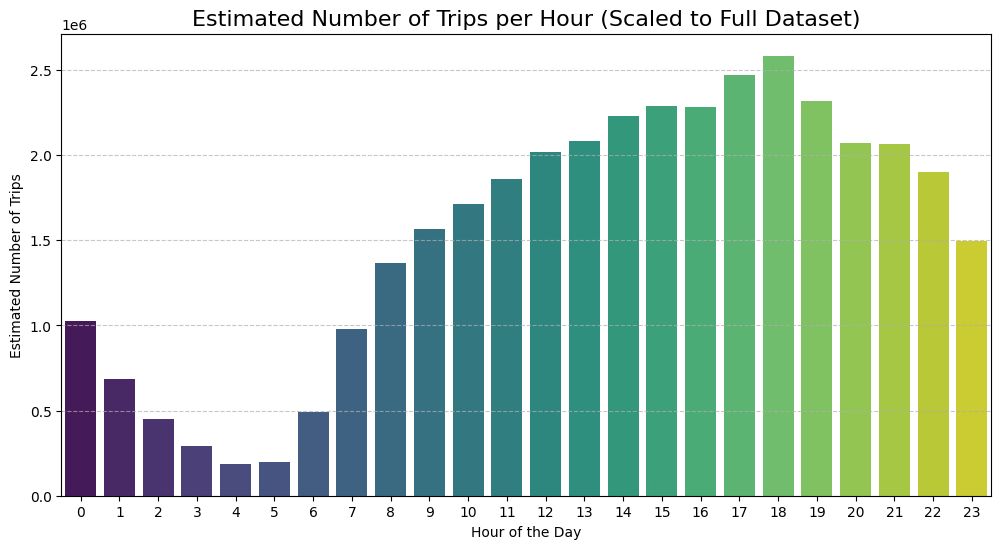

18:00 — 2,583,420 trips
17:00 — 2,470,800 trips
19:00 — 2,318,060 trips
15:00 — 2,285,580 trips
16:00 — 2,285,280 trips


In [130]:
# Scale up the number of trips
actual_trip_counts = hourly_trip_counts / 0.05


# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.05

plt.figure(figsize=(12,6))
sns.barplot(x=actual_trip_counts.index, y=actual_trip_counts.values, palette='viridis')

plt.title('Estimated Number of Trips per Hour (Scaled to Full Dataset)', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Estimated Number of Trips')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Find the busiest hour in the full dataset estimate
top_5_hours = actual_trip_counts.sort_values(ascending=False).head(5)


for hour, trips in top_5_hours.items():
    print(f"{hour}:00 — {int(trips):,} trips")



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

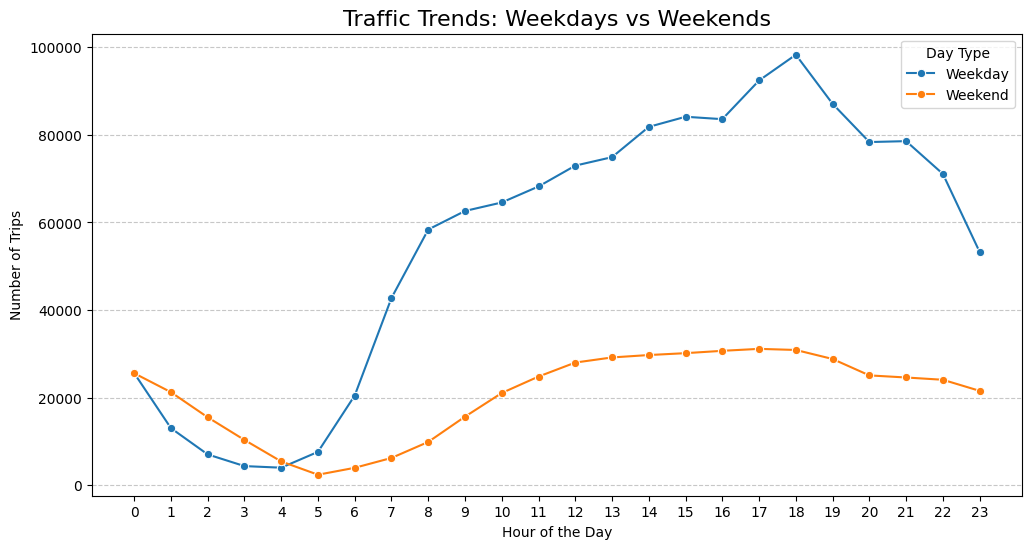

In [133]:
# Compare traffic trends for the week days and weekends

# Map day numbers to Weekday and Weekend
df['day_type'] = df['day'].apply(lambda x: 'Weekend' if x in [5, 6] else 'Weekday')
traffic_trends = df.groupby(['hour', 'day_type']).size().reset_index(name='trip_count')

plt.figure(figsize=(12,6))
sns.lineplot(data=traffic_trends, x='hour', y='trip_count', hue='day_type', marker='o')

plt.title('Traffic Trends: Weekdays vs Weekends', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Day Type')
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [137]:
# Find top 10 pickup and dropoff zones
top_pu_zones = df['PULocationID'].value_counts().head(10)
print("Top 10 Pickup Zones:")
print(top_pu_zones)

top_do_zones = df['DOLocationID'].value_counts().head(10)
print("\nTop 10 Dropoff Zones:")
print(top_do_zones)



Top 10 Pickup Zones:
PULocationID
132    96802
237    86899
161    85942
236    77509
162    65632
138    64167
186    63466
230    61313
142    60882
170    54487
Name: count, dtype: int64

Top 10 Dropoff Zones:
DOLocationID
236    81266
237    77549
161    71642
230    56395
170    54309
162    52247
142    51490
239    51256
141    48444
68     46348
Name: count, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [140]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

pickup_counts = df['PULocationID'].value_counts().rename('pickup_count')
dropoff_counts = df['DOLocationID'].value_counts().rename('dropoff_count')

pickup_dropoff_ratio = pd.concat([pickup_counts, dropoff_counts], axis=1).fillna(0)
pickup_dropoff_ratio['pickup_dropoff_ratio'] = pickup_dropoff_ratio['pickup_count'] / pickup_dropoff_ratio['dropoff_count']
top_10_ratio = pickup_dropoff_ratio.sort_values(by='pickup_dropoff_ratio', ascending=False).head(10)
print("Top 10 Pickup/Dropoff Ratios:\n", top_10_ratio)

bottom_10_ratio = pickup_dropoff_ratio.sort_values(by='pickup_dropoff_ratio', ascending=True).head(10)
print("\nBottom 10 Pickup/Dropoff Ratios:\n", bottom_10_ratio)

Top 10 Pickup/Dropoff Ratios:
      pickup_count  dropoff_count  pickup_dropoff_ratio
199         2.000          0.000                   inf
70       8345.000        993.000                 8.404
132     96802.000      20953.000                 4.620
138     64167.000      22244.000                 2.885
186     63466.000      40110.000                 1.582
114     24111.000      17537.000                 1.375
43      30750.000      22367.000                 1.375
249     40403.000      30465.000                 1.326
162     65632.000      52247.000                 1.256
161     85942.000      71642.000                 1.200

Bottom 10 Pickup/Dropoff Ratios:
      pickup_count  dropoff_count  pickup_dropoff_ratio
99          0.000          3.000                 0.000
30          0.000         18.000                 0.000
245         0.000         30.000                 0.000
176         0.000         12.000                 0.000
27          1.000         39.000                 0.026

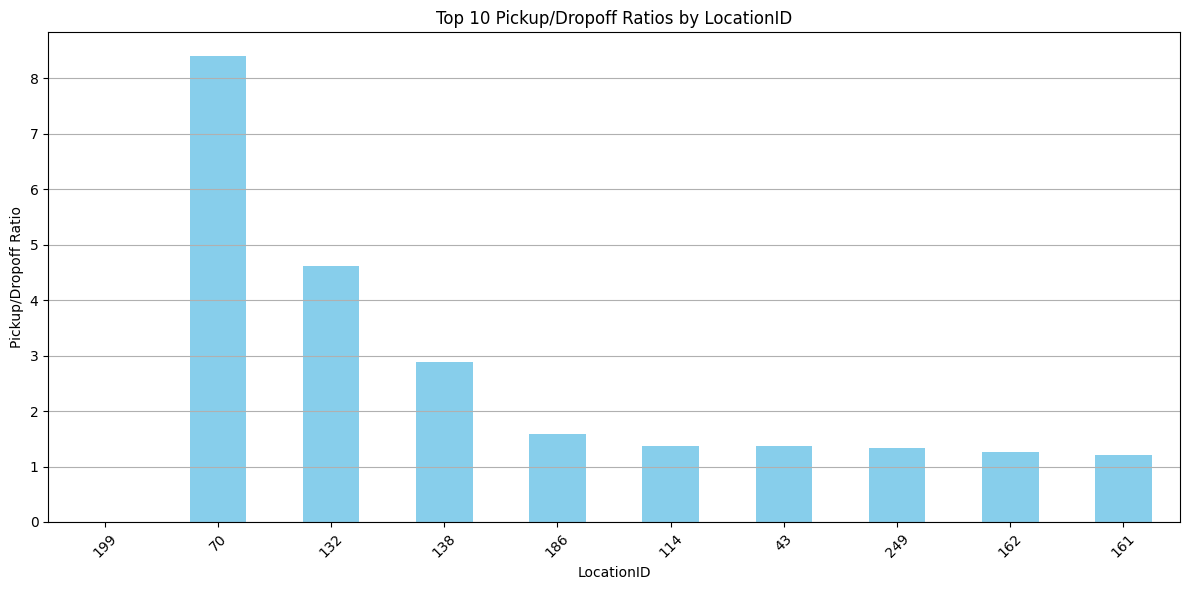

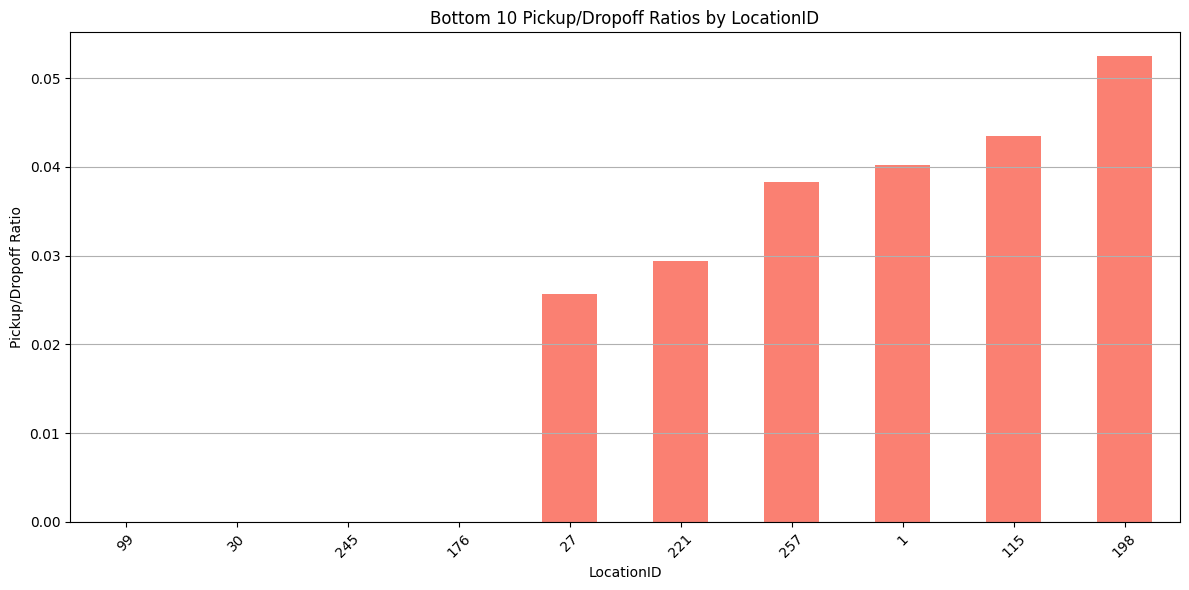

In [144]:
#Visualization of the top 10 and bottom 10 pickup/dropoff ratios

plt.figure(figsize=(12, 6))
top_10_ratio['pickup_dropoff_ratio'].plot(kind='bar', color='skyblue')
plt.title('Top 10 Pickup/Dropoff Ratios by LocationID')
plt.xlabel('LocationID')
plt.ylabel('Pickup/Dropoff Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot Bottom 10 Ratios
plt.figure(figsize=(12, 6))
bottom_10_ratio['pickup_dropoff_ratio'].plot(kind='bar', color='salmon')
plt.title('Bottom 10 Pickup/Dropoff Ratios by LocationID')
plt.xlabel('LocationID')
plt.ylabel('Pickup/Dropoff Ratio')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [148]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

night_df = df[(df['hour'] >= 23) | (df['hour'] <= 5)]
night_pickup_counts = night_df['PULocationID'].value_counts().head(10).reset_index()
night_pickup_counts.columns = ['LocationID', 'pickup_count']

# Merge with zones for names
top_night_pickup_zones = night_pickup_counts.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("Top 10 Night Pickup Zones:")
print(top_night_pickup_zones[['zone', 'pickup_count']])


Top 10 Night Pickup Zones:
                           zone  pickup_count
0                  East Village         15547
1                   JFK Airport         14541
2                  West Village         12471
3                  Clinton East         10462
4               Lower East Side          9627
5       Greenwich Village South          8749
6     Times Sq/Theatre District          8206
7  Penn Station/Madison Sq West          6968
8                 Midtown South          6143
9                  East Chelsea          6050


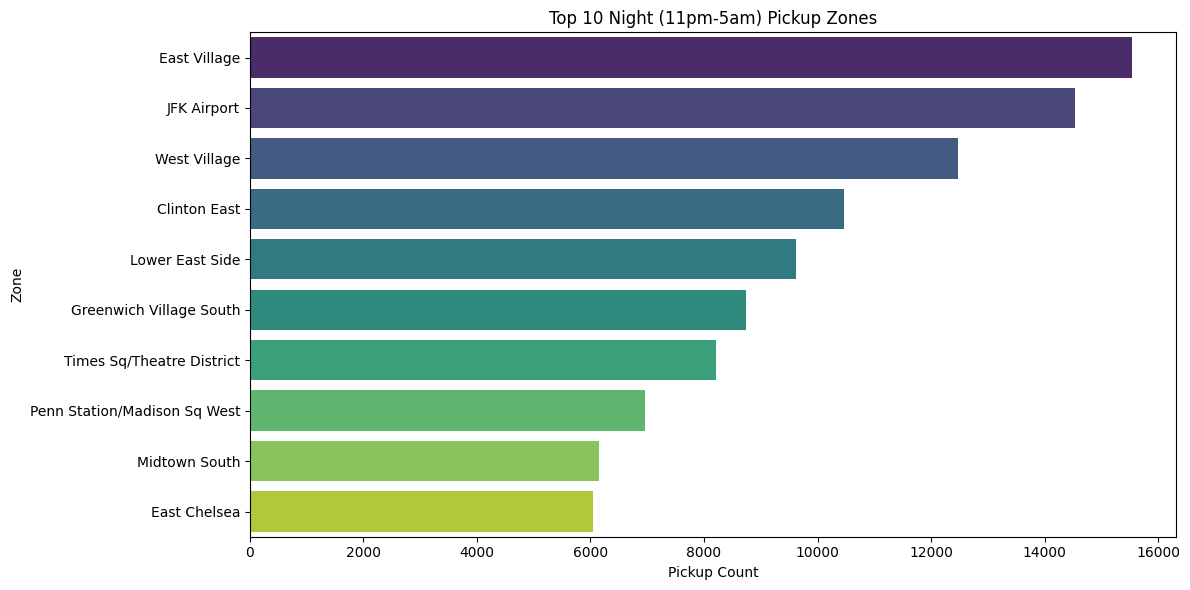

In [150]:
# Display Top 10 Night Pickup Zones
plt.figure(figsize=(12, 6))
sns.barplot(
    x='pickup_count', 
    y='zone', 
    data=top_night_pickup_zones.sort_values(by='pickup_count', ascending=False),
    palette='viridis'
)
plt.title('Top 10 Night (11pm-5am) Pickup Zones')
plt.xlabel('Pickup Count')
plt.ylabel('Zone')
plt.tight_layout()
plt.show()



Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [154]:
night_df = df[(df['hour'] >= 23) | (df['hour'] <= 5)]
day_df   = df[(df['hour'] > 5) & (df['hour'] < 23)]

# Calculate total revenue for each
night_revenue = night_df['total_amount'].sum()
day_revenue   = day_df['total_amount'].sum()

# Calculate total revenue overall
total_revenue = df['total_amount'].sum()

# Calculate percentage share
night_share = (night_revenue / total_revenue) * 100
day_share   = (day_revenue / total_revenue) * 100

# Print results
print(f"Nighttime Revenue Share (11pm-5am): {night_share:.2f}%")
print(f"Daytime Revenue Share (5am-11pm): {day_share:.2f}%")

Nighttime Revenue Share (11pm-5am): 12.06%
Daytime Revenue Share (5am-11pm): 87.94%


In [152]:
# Filter for night hours (11 PM to 5 AM)

night_dropoff_counts = night_df['DOLocationID'].value_counts().head(10).reset_index()
night_dropoff_counts.columns = ['LocationID', 'dropoff_count']

# Merge with zones for names
top_night_dropoff_zones = night_dropoff_counts.merge(zones[['LocationID', 'zone']], on='LocationID', how='left')

print("\nTop 10 Night Dropoff Zones:")
print(top_night_dropoff_zones[['zone', 'dropoff_count']])


Top 10 Night Dropoff Zones:
                        zone  dropoff_count
0               East Village           8312
1               Clinton East           6873
2                Murray Hill           6265
3               East Chelsea           5858
4                   Gramercy           5756
5            Lenox Hill West           5271
6             Yorkville West           4977
7               West Village           4943
8  Times Sq/Theatre District           4641
9            Lower East Side           4381


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [156]:
# Analyse the fare per mile per passenger for different passenger counts

valid_fare_data = df[(df['trip_distance'] > 0) & (df['passenger_count'] > 0)]

valid_fare_data['fare_per_mile_per_passenger'] = valid_fare_data['fare_amount'] / (valid_fare_data['trip_distance'] * valid_fare_data['passenger_count'])
fare_analysis = valid_fare_data.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

print(fare_analysis)

   passenger_count  fare_per_mile_per_passenger
0            1.000                       11.238
1            2.000                        6.588
2            3.000                        4.025
3            4.000                        4.660
4            5.000                        1.727
5            6.000                        1.356


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

  pickup_day_name  fare_per_mile
1          Monday         11.271
5         Tuesday         12.385
6       Wednesday         11.349
4        Thursday         11.505
0          Friday         11.192
2        Saturday         11.160
3          Sunday         12.896
    hour  fare_per_mile
0      0         10.944
1      1         11.672
2      2         10.429
3      3         11.378
4      4         14.846
5      5         14.912
6      6         11.661
7      7         10.569
8      8         10.635
9      9         10.614
10    10         13.321
11    11         11.178
12    12         12.268
13    13         12.219
14    14         11.918
15    15         12.766
16    16         14.183
17    17         12.194
18    18         11.769
19    19         11.822
20    20          9.828
21    21          9.764
22    22         10.392
23    23         11.035


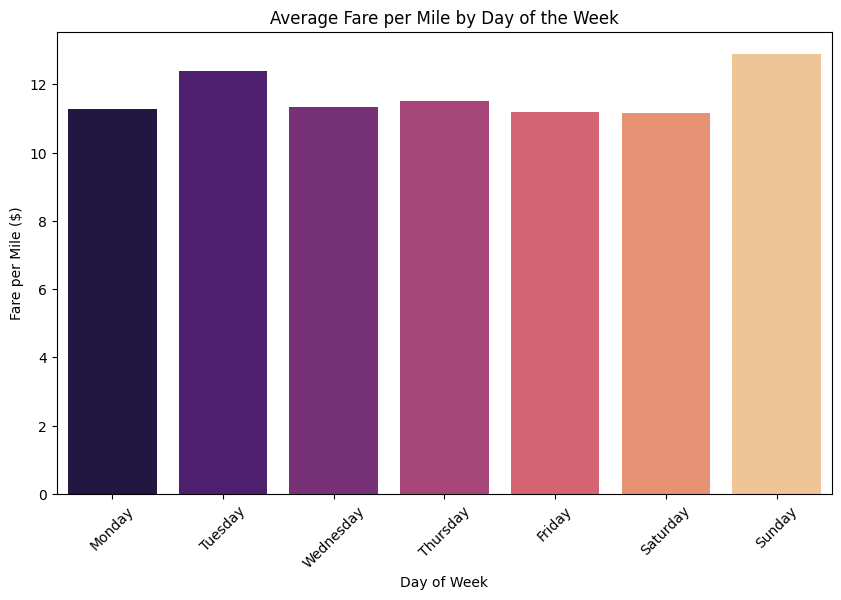

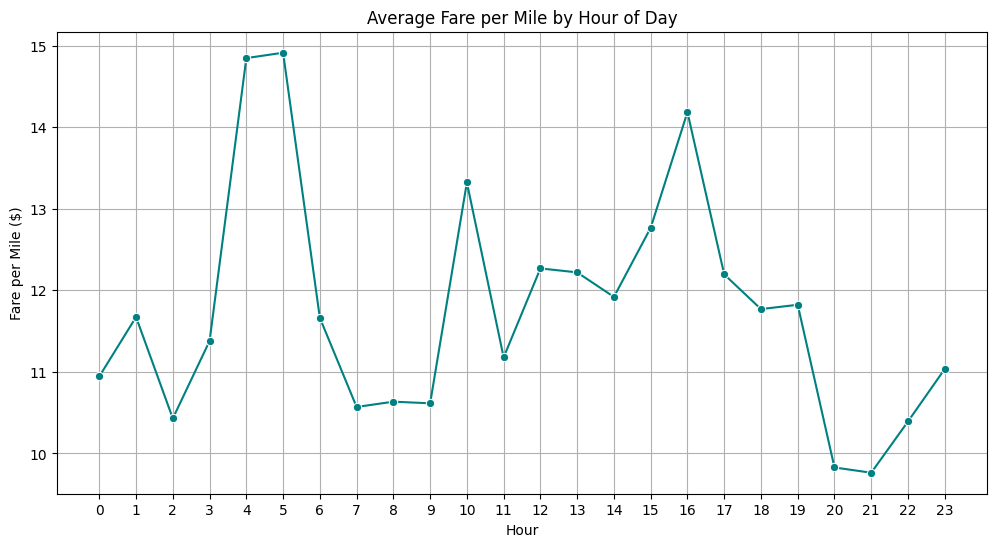

In [164]:
# Compare the average fare per mile for different days and for different times of the day

valid_fares = df[df['trip_distance'] > 0].copy()

valid_fares['fare_per_mile'] = valid_fares['fare_amount'] / valid_fares['trip_distance']
df['pickup_day_name'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()

valid_fares = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0)].copy()
valid_fares['fare_per_mile'] = valid_fares['fare_amount'] / valid_fares['trip_distance']
fare_per_mile_day = valid_fares.groupby('pickup_day_name')['fare_per_mile'].mean().reset_index()

from pandas.api.types import CategoricalDtype

day_order = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
fare_per_mile_day['pickup_day_name'] = fare_per_mile_day['pickup_day_name'].astype(day_order)
fare_per_mile_day = fare_per_mile_day.sort_values('pickup_day_name')

fare_per_mile_hour = valid_fares.groupby('hour')['fare_per_mile'].mean().reset_index()

print(fare_per_mile_day)

print(fare_per_mile_hour)

#Visualize both , day and hour fare per mile

plt.figure(figsize=(10,6))
sns.barplot(data=fare_per_mile_day, x='pickup_day_name', y='fare_per_mile', palette='magma')
plt.title('Average Fare per Mile by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Fare per Mile ($)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(data=fare_per_mile_hour, x='hour', y='fare_per_mile', marker='o', color='teal')
plt.title('Average Fare per Mile by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fare per Mile ($)')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()



**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [166]:
# Compare fare per mile for different vendors

valid_trips = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0)].copy()
valid_trips['fare_per_mile'] = valid_trips['fare_amount'] / valid_trips['trip_distance']
# Group by VendorID and calculate average fare per mile
fare_per_mile_vendor = valid_trips.groupby('VendorID')['fare_per_mile'].mean().reset_index()
fare_per_mile_vendor = fare_per_mile_vendor.sort_values(by='fare_per_mile', ascending=False)
print(fare_per_mile_vendor)

   VendorID  fare_per_mile
1         2         12.658
0         1          8.864


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [168]:
# Defining distance tiers

def categorize_distance(distance):
    if distance <= 2:
        return '0-2 miles'
    elif distance <= 5:
        return '2-5 miles'
    else:
        return '5+ miles'

df['distance_tier'] = df['trip_distance'].apply(categorize_distance)

valid_trips = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0)].copy()

# fare per mile
valid_trips['fare_per_mile'] = valid_trips['fare_amount'] / valid_trips['trip_distance']

tiered_fare_rates = valid_trips.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()

# Sort values 
tiered_fare_rates = tiered_fare_rates.sort_values(by=['distance_tier', 'VendorID'])

print(tiered_fare_rates)

   VendorID distance_tier  fare_per_mile
0         1     0-2 miles         11.123
3         2     0-2 miles         18.285
1         1     2-5 miles          6.381
4         2     2-5 miles          6.549
2         1      5+ miles          4.424
5         2      5+ miles          4.503


##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

  distance_range  tip_percentage
0         0-2 mi          23.959
1         2-5 mi          18.766
2        5-10 mi          19.537
3       10-20 mi          16.064
4       20-50 mi          14.154
5         50+ mi           7.098
   passenger_count  tip_percentage
0            1.000          21.953
1            2.000          20.457
2            3.000          18.977
3            4.000          17.378
4            5.000          20.520
5            6.000          20.581
    hour  tip_percentage
0      0          26.596
1      1          21.209
2      2          20.787
3      3          20.575
4      4          18.978
5      5          17.392
6      6          18.273
7      7          19.578
8      8          19.981
9      9          19.682
10    10          19.241
11    11          19.161
12    12          19.180
13    13          19.989
14    14          20.907
15    15          25.265
16    16          20.939
17    17          24.440
18    18          22.250
19    19          22.312

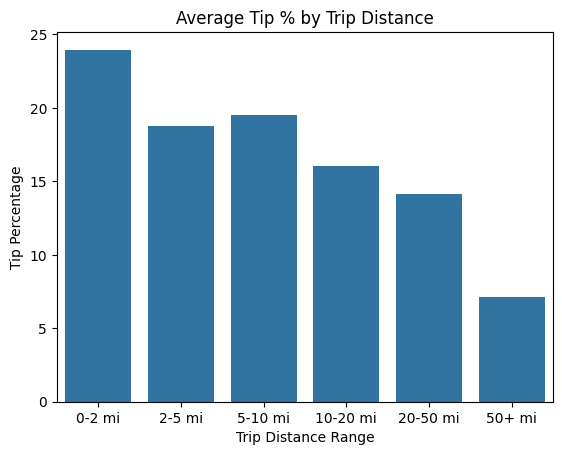

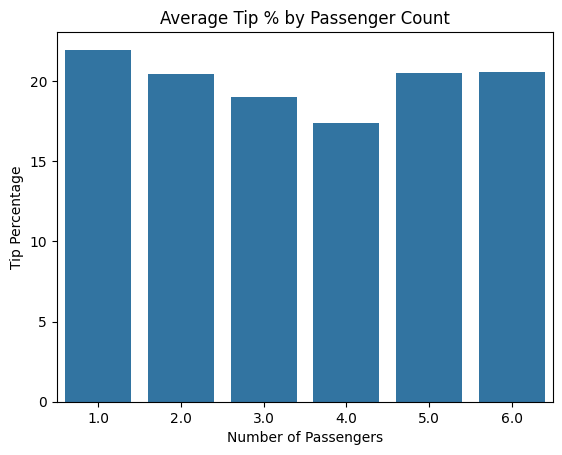

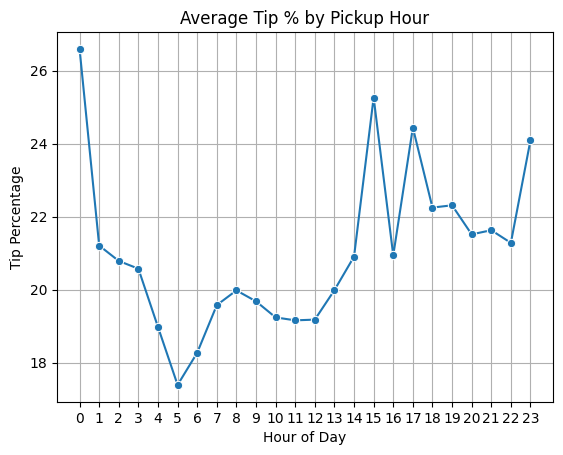

In [170]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
df['tip_percentage'] = (df['tip_amount'] / df['fare_amount']) * 100
distance_bins = [0, 2, 5, 10, 20, 50, df['trip_distance'].max()]
distance_labels = ['0-2 mi', '2-5 mi', '5-10 mi', '10-20 mi', '20-50 mi', '50+ mi']

df['distance_range'] = pd.cut(df['trip_distance'], bins=distance_bins, labels=distance_labels)

tip_by_distance = df.groupby('distance_range')['tip_percentage'].mean().reset_index()
print(tip_by_distance)

tip_by_passengers = df.groupby('passenger_count')['tip_percentage'].mean().reset_index()
print(tip_by_passengers)

tip_by_hour = df.groupby('hour')['tip_percentage'].mean().reset_index()
print(tip_by_hour)


sns.barplot(data=tip_by_distance, x='distance_range', y='tip_percentage')
plt.title('Average Tip % by Trip Distance')
plt.ylabel('Tip Percentage')
plt.xlabel('Trip Distance Range')
plt.show()


sns.barplot(data=tip_by_passengers, x='passenger_count', y='tip_percentage')
plt.title('Average Tip % by Passenger Count')
plt.ylabel('Tip Percentage')
plt.xlabel('Number of Passengers')
plt.show()

sns.lineplot(data=tip_by_hour, x='hour', y='tip_percentage', marker='o')
plt.title('Average Tip % by Pickup Hour')
plt.ylabel('Tip Percentage')
plt.xlabel('Hour of Day')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

Average Trip Distance (Low Tips): 3.825958951826863
Average Trip Distance (High Tips): 2.2947042584434647
Average Passenger Count (Low Tips): 1.425605067005892
Average Passenger Count (High Tips): 1.363210964268233
Payment Type Distribution (Low Tips):
 payment_type
2   64.999
1   30.378
4    2.792
3    1.832
Name: proportion, dtype: float64

Payment Type Distribution (High Tips):
 payment_type
1   99.992
3    0.004
2    0.002
4    0.002
Name: proportion, dtype: float64


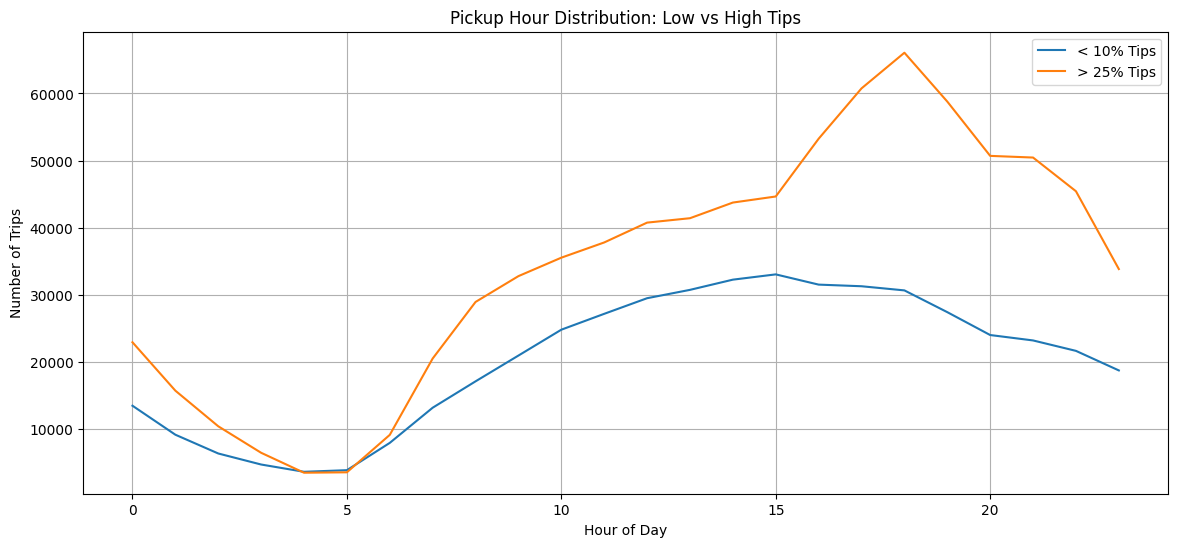

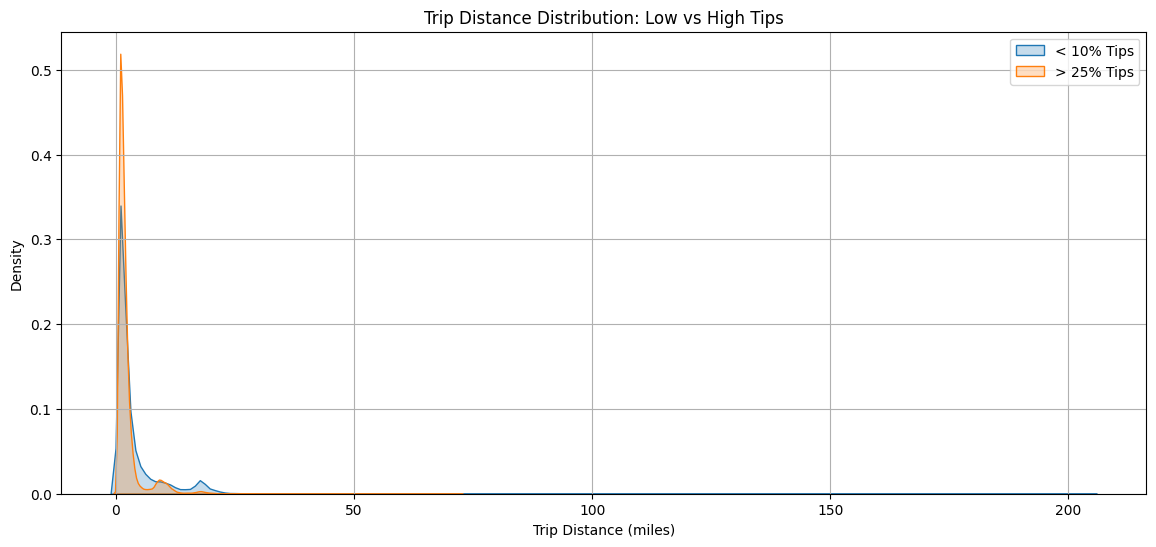

In [255]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

low_tips = df[df['tip_percentage'] < 10]
high_tips = df[df['tip_percentage'] > 25]

print("Average Trip Distance (Low Tips):", low_tips['trip_distance'].mean())
print("Average Trip Distance (High Tips):", high_tips['trip_distance'].mean())

print("Average Passenger Count (Low Tips):", low_tips['passenger_count'].mean())
print("Average Passenger Count (High Tips):", high_tips['passenger_count'].mean())

print("Payment Type Distribution (Low Tips):\n", low_tips['payment_type'].value_counts(normalize=True) * 100)
print("\nPayment Type Distribution (High Tips):\n", high_tips['payment_type'].value_counts(normalize=True) * 100)

pickup_hour_low = low_tips['hour'].value_counts().sort_index()
pickup_hour_high = high_tips['hour'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(x=pickup_hour_low.index, y=pickup_hour_low.values, label='< 10% Tips')
sns.lineplot(x=pickup_hour_high.index, y=pickup_hour_high.values, label='> 25% Tips')
plt.title('Pickup Hour Distribution: Low vs High Tips')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,6))
sns.kdeplot(low_tips['trip_distance'], label='< 10% Tips', shade=True)
sns.kdeplot(high_tips['trip_distance'], label='> 25% Tips', shade=True)
plt.title('Trip Distance Distribution: Low vs High Tips')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

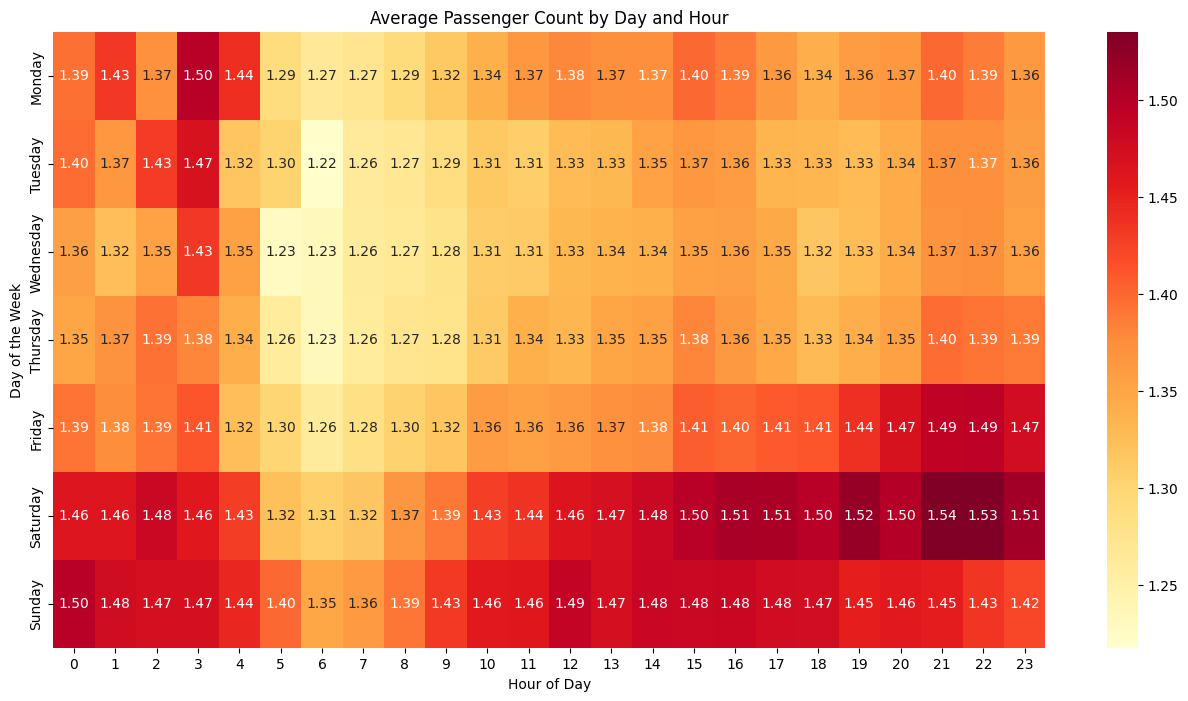

In [172]:
# See how passenger count varies across hours and days

heatmap_data = df.pivot_table(
    values='passenger_count',
    index='pickup_day_name',
    columns='hour',
    aggfunc='mean'
)

# Make sure the days are ordered correctly
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
heatmap_data = heatmap_data.reindex(day_order)

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlOrRd')
plt.title('Average Passenger Count by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of the Week')
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

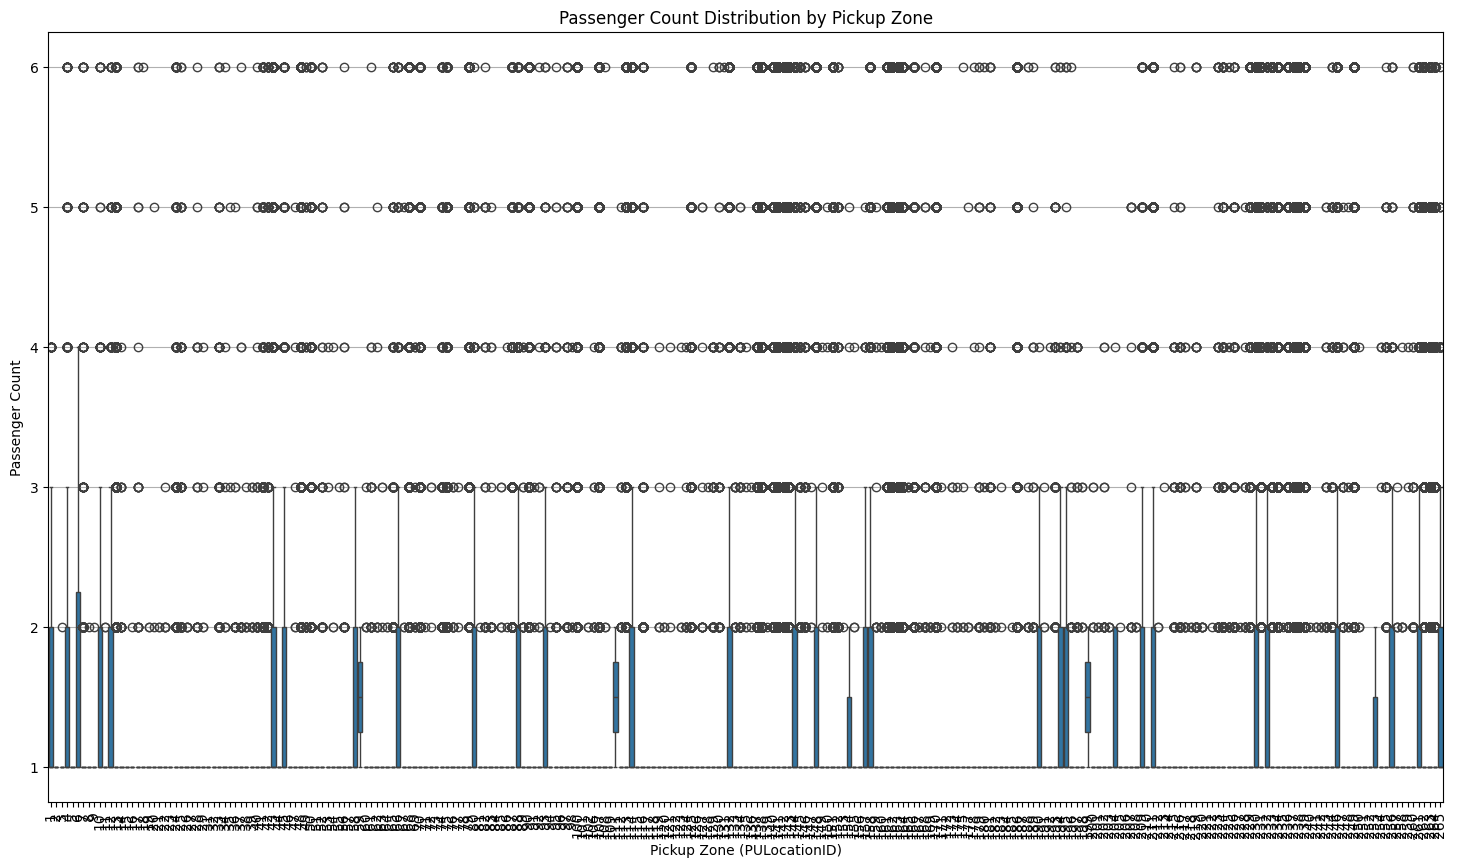

In [259]:
# How does passenger count vary across zones

plt.figure(figsize=(18, 10))
sns.boxplot(x='PULocationID', y='passenger_count', data=df)
plt.title('Passenger Count Distribution by Pickup Zone')
plt.xlabel('Pickup Zone (PULocationID)')
plt.ylabel('Passenger Count')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better spacing
plt.grid(True, axis='y')
plt.show()

In [261]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

avg_passenger_count_per_zone = df.groupby('PULocationID')['passenger_count'].mean().reset_index()
avg_passenger_count_per_zone.columns = ['PULocationID', 'avg_passenger_count']

# Step 2: Merge the average passenger count into the zones_with_trips GeoDataFrame
zones_with_trips = zones.merge(avg_passenger_count_per_zone, on='PULocationID', how='left')

# Check the first few rows to confirm the new column is added
print(zones_with_trips.head())


   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1       0.116       0.001           Newark Airport           1   
1         2       0.433       0.005              Jamaica Bay           2   
2         3       0.084       0.000  Allerton/Pelham Gardens           3   
3         4       0.044       0.000            Alphabet City           4   
4         5       0.092       0.000            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   

   PULocationID  trip_count  avg_passenger_count  
0         1.000     214.000                1.603  
1         2.00

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [174]:
# How often is each surcharge applied?

surcharge_columns = ['mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']

# Calculate the count of non-zero values for each surcharge
surcharge_counts = {col: (df[col] > 0).sum() for col in surcharge_columns}

# Calculate the total number of trips (rows) in the dataset
total_trips = len(df)

# Calculate the proportion of trips where each surcharge is applied
surcharge_proportions = {col: surcharge_counts[col] / total_trips for col in surcharge_columns}

# Display the results
for col in surcharge_columns:
    print(f"{col}: {surcharge_counts[col]} times applied ({surcharge_proportions[col]*100:.2f}% of trips)")


mta_tax: 1814301 times applied (99.08% of trips)
improvement_surcharge: 1830653 times applied (99.98% of trips)
congestion_surcharge: 1690548 times applied (92.33% of trips)
airport_fee: 0 times applied (0.00% of trips)


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

In [ ]:
Increase cab availability during peak hours (7–9 AM and 16-19 hours), especially on Thursday. 
Reduce cab availability on Sunday and Monday to save cost and wait time. Allign more cans in the month of May and put some to rest in September.

Reassign cabs dynamically to airport pickup zones, during early morning hours to counter delayed traffic. 
Find alternate route for like airport to Midtown where there is speed bottleneck.

Use route-speed analysis to avoid heavily congested routes during peak hours. 
Prioritise faster alternate routes or suggest optimized pick-up points to customers via apps.

Implement predictive scheduling based on historical trip durations by route and hour to preempt traffic delays.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

In [ ]:
Deploy additional cabs in Midtown Manhattan, JFK, and LaGuardia during peak hours.

Strategically station cabs near entertainment and office zones during late-night and early morning hours. East Village, JFK, West Village, Clinton east are more active during night.

Reduce idle times by rotating cabs from low-demand areas to anticipated surge areas.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

In [ ]:
Make trips over 5 miles cost different amounts depending on time of day, especially during rush hour and at night.
Charge more for rides starting at busy airports like JFK and LaGuardia.
Show riders suggested tip amounts or give rewards for tipping on trips longer than 2 miles or during slow hours.
Make short trips (less than 1 mile) cheaper during slow times to get more customers. During less active hours ( 2 - 6) reduce price and send offers to increase the usage of cabs.
Compare prices to competitors and adjust costs for popular routes like Midtown to JFK.